# Confidence of a Classical Neural Network
This notebook examines the confidence probabilities of a classical neural network. I will use the *MNIST* and *FashionMNIST* datasets to demonstrate the consequences if confidence within the prediction process is missing.

Import all necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from collections import OrderedDict

# PyTorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import helper

## Load the data

Use `Dataloader` to load the data and store it in the `data` directory.

The dataset is split into two parts, training and testing.

The testing sets is used to measure the model's performance on data it hasn't seen yet. 

Define how to transform the datasets

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

Define the datasets and where to store them

In [3]:
# datasets
trainset = torchvision.datasets.MNIST('../data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('../data',
    download=True,
    train=False,
    transform=transform)

Load the datasets

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Print the number of datasets

In [5]:
print(len(trainloader.dataset))

60000


Print the number of batches

In [6]:
print(len(trainloader))

469


Print some examples of the dataset 

In [7]:
batch_idx, (images, labels) = next(enumerate(testloader))

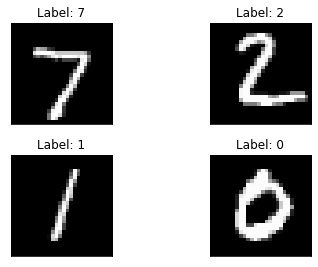

In [8]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

### Building and training the classifier
Define the neural network: 
* input layer of 28 x 28 = 784 input nodes
* hidden layer of 1024 nodes
* output layer of 10 nodes

In [9]:
input_layer_size = 28*28 # image size of 28 x 28 pixels
hidden_layer_size = 1024
output_layer_size = 10   # amount of categories

In [10]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.out = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.out(x)
        return x

Initialize the Neural Network

In [11]:
neuralNet = NeuralNet(input_layer_size, hidden_layer_size, output_layer_size)

In [12]:
log_softmax = nn.LogSoftmax(dim=1)

Train the Neural Network on the MNIST training set.

In [13]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(neuralNet.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0
for epoch in range(10):  # loop over the dataset multiple times

    for i, (images, labels) in enumerate(trainloader):

        # flatten the imiga into a 784 element vector
        images.resize_(images.size()[0], 784)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = log_softmax(neuralNet(images))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # every 100 mini-batches...
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            
            running_loss = 0.0
print('Finished Training')

[1,   100] loss: 1.788
[1,   200] loss: 0.980
[1,   300] loss: 0.693
[1,   400] loss: 0.572
[2,   100] loss: 0.836
[2,   200] loss: 0.433
[2,   300] loss: 0.421
[2,   400] loss: 0.406
[3,   100] loss: 0.651
[3,   200] loss: 0.374
[3,   300] loss: 0.365
[3,   400] loss: 0.350
[4,   100] loss: 0.583
[4,   200] loss: 0.332
[4,   300] loss: 0.334
[4,   400] loss: 0.331
[5,   100] loss: 0.540
[5,   200] loss: 0.321
[5,   300] loss: 0.312
[5,   400] loss: 0.304
[6,   100] loss: 0.524
[6,   200] loss: 0.294
[6,   300] loss: 0.298
[6,   400] loss: 0.292
[7,   100] loss: 0.499
[7,   200] loss: 0.291
[7,   300] loss: 0.276
[7,   400] loss: 0.278
[8,   100] loss: 0.475
[8,   200] loss: 0.280
[8,   300] loss: 0.277
[8,   400] loss: 0.268
[9,   100] loss: 0.441
[9,   200] loss: 0.257
[9,   300] loss: 0.255
[9,   400] loss: 0.265
[10,   100] loss: 0.433
[10,   200] loss: 0.255
[10,   300] loss: 0.255
[10,   400] loss: 0.249
Finished Training


Display a single image and its *Softmax* distribution.

Predicted Digit = 1
Max probability value =  0.9678752


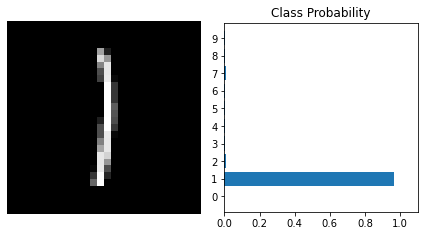

In [14]:
images, labels = next(iter(testloader))

img = images[40].view(1, 784)
with torch.no_grad():
    logps = log_softmax(neuralNet(img))

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print("Max probability value = ", max(probab))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

Test the Neural Network on the MNIST testing set.

In [15]:
correct_count, all_count = 0, 0
for images,labels in testloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = neuralNet(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy = {:.1f} %".format((correct_count/all_count)*100))

Number Of Images Tested = 157

Model Accuracy = 93.0 %


### Testing the network on Out-Of-Distribution examples
Recap of what we have done so far:
* We loaded the MNIST dataset existing of the training and the testing dataset
* We build a simple NN consisting of just three layers
* We uset the MNIST training dataset to trained the network
* We tested the NN and got a accuracy of more than 90 %

Now lets see what happens, if we present the network unseen data from the **FashionMNIST** data set.

In [17]:
# FashionMNIST test dataset
fashiontestset = torchvision.datasets.FashionMNIST('../data',
    download=True,
    train=False,
    transform=transform)

In [18]:
fashiontestloader = torch.utils.data.DataLoader(fashiontestset, batch_size=64, shuffle=False)

In [19]:
examples = enumerate(fashiontestloader)
batch_idx, (example_data, example_targets) = next(examples)

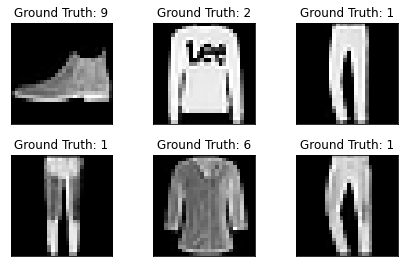

In [20]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

Predicted Category = 4
Max probability value =  0.9072733


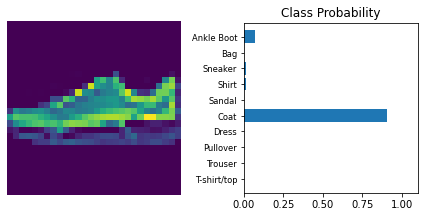

In [21]:
images, labels = next(iter(fashiontestloader))

img = images[9].view(1, 784)
with torch.no_grad():
    logps = log_softmax(neuralNet(img))

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Category =", probab.index(max(probab)))
print("Max probability value = ", max(probab))
# view_classify(img.view(1, 28, 28), ps)
helper.view_classify(img.resize_(1, 28, 28), ps, version = "Fashion")

In [22]:
correct_count, all_count = 0, 0
for images,labels in fashiontestloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = neuralNet(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
          correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy = {:.1f} %".format((correct_count/all_count)*100))

Number Of Images Tested = 157

Model Accuracy = 8.9 %


## Result of the Out-Of-Distribution examples
Because the neural network hasn't been trained on the *FashionMNIST* data, the accuracy is, as expected around 10 %, because for 10 equally distributed classes the accuracy should be approximately 10 % by chance!

The network assigns to each input one of the ten categories depending on the output of the *(Log)Softmax* function. The category with the highest result wins and will be predicted, even if the winning category has just 11 % after *Softmax*.

Does a bad accuracy also mean a low confidence in the predicted values? In the picture below, the confidence is indeed not so high. The maximal probability value is 26.4 %.
<img src='../pictures/fashion_bad1.png' width=500px>
But this is not universally valid, as can be seen in the next two pictures:
<img src='../pictures/fashion_good1.png' width=500px>
 
<img src='../pictures/fashion_good2.png' width=500px>
In the two pictures above, the network is very confident with around 98 %, that it detects a bag and a shoe, which is in both cases not correct.


**Therefore a bad accuracy does not automatically mean a low confidence**

Due to the fact, that the network is not able to detect unseen categories it tries to predict them and assigns a result to each of them. 

## Conclusion
To add reliability and confidence to the prediction of neural networks, the network must be able to express its (un)certainty about the data it is confronted with. 